In [ ]:
%cd /content/drive/MyDrive/agender/model/Secondary/YOLOv8

/content/drive/MyDrive/agender/model/Secondary/YOLOv8


# 前処理の修正

jetsonに組み込んだ際に精度が低かったため、前処理のコードを確認したところ、画像の前処理をする際に、決められたサイズ分だけcenter cropするようになっていた。  
issueもあった。  
https://github.com/ultralytics/ultralytics/issues/3029

原因の箇所  
yolo/v8/classify/train.py build_dataset  
-> yolo/v8/data/dataset.py ClassificationDataset classify_transforms  
-> yolo/v8/data/augment.py classify_transforms CenterCrop  

```
class CenterCrop:
    """YOLOv8 CenterCrop class for image preprocessing, i.e. T.Compose([CenterCrop(size), ToTensor()])"""

    def __init__(self, size=640):
        """Converts an image from numpy array to PyTorch tensor."""
        super().__init__()
        self.h, self.w = (size, size) if isinstance(size, int) else size

    def __call__(self, im):  # im = np.array HWC
        imh, imw = im.shape[:2]
        m = min(imh, imw)  # min dimension
        top, left = (imh - m) // 2, (imw - m) // 2
        return cv2.resize(im[top:top + m, left:left + m], (self.w, self.h), interpolation=cv2.INTER_LINEAR)


```

## 挙動確認

In [ ]:
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
image_files = glob("/content/drive/MyDrive/agender/model/Secondary/Dataset/All-Age-Faces-Dataset/split_dataset_gender/test/*/*")

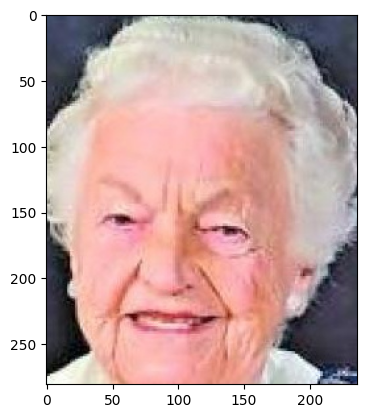

In [ ]:
# オリジナル画像
im = cv2.imread(image_files[-1])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

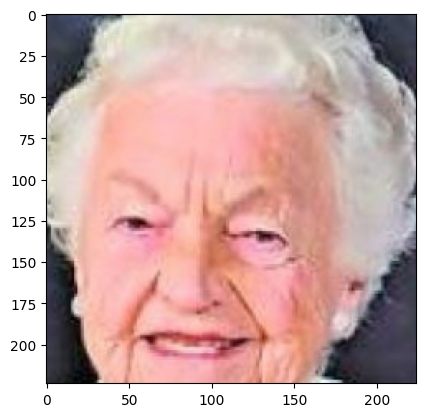

In [ ]:
# 現状のコード（CenterCrop）でリサイズ
size = 224

imh, imw = im.shape[:2]
m = min(imh, imw)  # min dimension
top, left = (imh - m) // 2, (imw - m) // 2
im_resize = cv2.resize(im[top:top + m, left:left + m], (size, size), interpolation=cv2.INTER_LINEAR)

plt.imshow(im_resize)

detectionでは yolo/v8/data/augment.pyのLetterBoxクラスを使用している。  
このクラスにはbboxの座標修正も含まれている。  
yolo/v8/data/augment.pyにClassifyLetterBoxクラスがあったので、この挙動を確認する。
```
class ClassifyLetterBox:
    """YOLOv8 LetterBox class for image preprocessing, i.e. T.Compose([LetterBox(size), ToTensor()])"""

    def __init__(self, size=(640, 640), auto=False, stride=32):
        """Resizes image and crops it to center with max dimensions 'h' and 'w'."""
        super().__init__()
        self.h, self.w = (size, size) if isinstance(size, int) else size
        self.auto = auto  # pass max size integer, automatically solve for short side using stride
        self.stride = stride  # used with auto

    def __call__(self, im):  # im = np.array HWC
        imh, imw = im.shape[:2]
        r = min(self.h / imh, self.w / imw)  # ratio of new/old
        h, w = round(imh * r), round(imw * r)  # resized image
        hs, ws = (math.ceil(x / self.stride) * self.stride for x in (h, w)) if self.auto else self.h, self.w
        top, left = round((hs - h) / 2 - 0.1), round((ws - w) / 2 - 0.1)
        im_out = np.full((self.h, self.w, 3), 114, dtype=im.dtype)
        im_out[top:top + h, left:left + w] = cv2.resize(im, (w, h), interpolation=cv2.INTER_LINEAR)
        return im_out
```

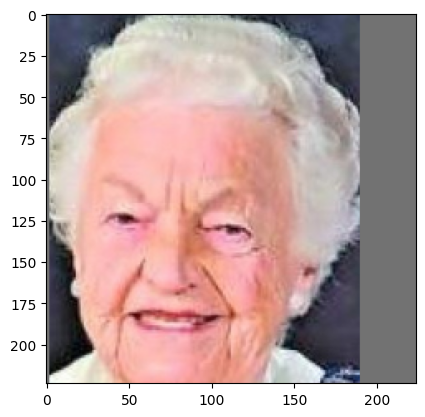

In [ ]:
# ClassifyLetterBoxでリサイズ
import numpy as np
import math

size = 224
stride = 32

imh, imw = im.shape[:2]
r = min(224 / imh, 224 / imw)  # ratio of new/old
h, w = round(imh * r), round(imw * r)  # resized image
hs, ws = (math.ceil(x / stride) * stride for x in (h, w))
top, left = round((hs - h) / 2 - 0.1), round((ws - w) / 2 - 0.1)
im_out = np.full((224, 224, 3), 114, dtype=im.dtype)
im_out[top:top + h, left:left + w] = cv2.resize(im, (w, h), interpolation=cv2.INTER_LINEAR)

plt.imshow(im_out)

とりあえずaugmentationsなし、ClassifyLetterBoxを使うように修正して学習を行う。

## コード修正したultralyticsをインストール

In [ ]:
# 2023.07.16
#!git clone https://github.com/ultralytics/ultralytics.git
# これをもとにコードを修正した

Cloning into 'ultralytics'...
remote: Enumerating objects: 13265, done.
remote: Counting objects: 100% (2539/2539), done.
remote: Compressing objects: 100% (1328/1328), done.
remote: Total 13265 (delta 1648), reused 1903 (delta 1174), pack-reused 10726
Receiving objects: 100% (13265/13265), 7.77 MiB | 14.63 MiB/s, done.
Resolving deltas: 100% (8810/8810), done.
Updating files: 100% (416/416), done.


In [ ]:
%cd /content/drive/MyDrive/agender/model/Secondary/YOLOv8/ultralytics

/content/drive/MyDrive/agender/model/Secondary/YOLOv8/ultralytics


In [ ]:
!pip3 install -e .

Obtaining file:///content/drive/MyDrive/agender/model/Secondary/YOLOv8/ultralytics
  Preparing metadata (setup.py) ... done
  Running setup.py develop for ultralytics


# 学習

In [ ]:
dataset_path = "/content/drive/MyDrive/agender/model/Secondary/Dataset/All-Age-Faces-Dataset/split_dataset_gender"
!yolo classify train data={dataset_path} model=yolov8s-cls.pt epochs=300 imgsz=224 batch=192 device=0 name=gender


New https://pypi.org/project/ultralytics/8.0.136 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.135 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=/content/drive/MyDrive/agender/model/Secondary/Dataset/All-Age-Faces-Dataset/split_dataset_gender, epochs=300, patience=50, batch=192, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=gender, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, li

## 精度評価

In [ ]:
dataset_path = "/content/drive/MyDrive/agender/model/Secondary/Dataset/All-Age-Faces-Dataset/split_dataset_gender"
!yolo classify val model="runs/classify/gender2/weights/best.pt" data={dataset_path} imgsz=224 split=test

Ultralytics YOLOv8.0.135 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-cls summary (fused): 73 layers, 5077762 parameters, 0 gradients
               classes   top1_acc   top5_acc: 100% 36/36 [00:02<00:00, 13.31it/s]
                   all      0.918          1
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/drive/MyDrive/agender/model/Secondary/YOLOv8/ultralytics/runs/classify/val4


# TensorRT

In [ ]:
!pip3 install onnx

from ultralytics import YOLO
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 89.3 MB/s eta 0:00:00


In [ ]:
file_path = "runs/classify/gender2/weights/best.pt"
model = YOLO(file_path)

In [ ]:
input_w = 224
input_h = 224

onnx_file_name = "yolov8s_cls_gender.onnx"

dummy_input = torch.randn(1, 3, input_h, input_w, device="cpu")
input_names = ["input1"]
output_names = ["output1"]

torch.onnx.export(model.model.eval(),
                  dummy_input,
                  onnx_file_name,
                  verbose=True,
                  input_names=input_names,
                  output_names=output_names,
                  opset_version=11)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

